# Sentiment Analysis in Python

In this notebook i will be doing sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner)-Bag of Words approach
2. Roberta Pretrained Model from huggingface
3. Huggingface Pipeline

# Step-0 Read in data and NLTK Basics

In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import nltk

In [5]:
# Read in data
df=pd.read_csv(r"C:\Users\enesm\OneDrive\Masaüstü\My_Workspaces\LLM_NLP\Roberta_and_NLTK_Sentiment_Analysis\Data\reviews.csv")

In [6]:
print(df.shape)
df.head()

(10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### Quick EDA

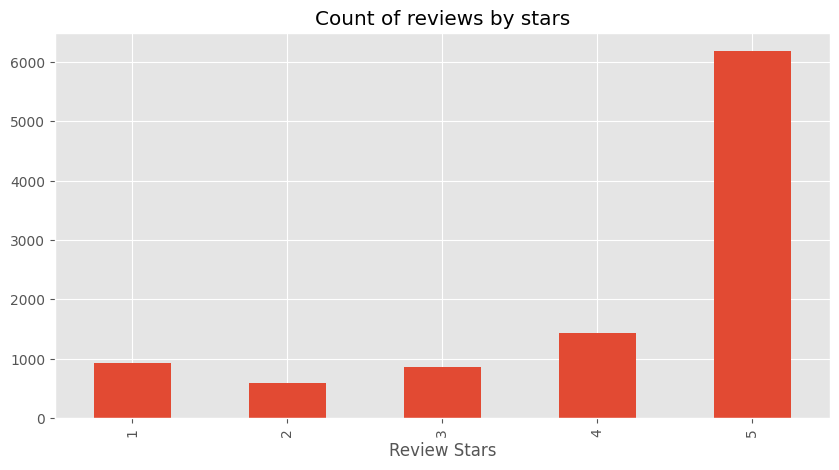

In [6]:
ax= df.Score.value_counts().sort_index()    \
    .plot(  kind='bar',
            title='Count of reviews by stars',
            figsize=(10,5))

ax.set_xlabel("Review Stars")
plt.show()

### Basic NLTK

In [7]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
nltk.download('punkt')
tokens=nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enesm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
nltk.download('averaged_perceptron_tagger')
tagged=nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\enesm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities=nltk.chunk.ne_chunk(tagged)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\enesm\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\enesm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step-1 VADER Sentiment Scoring
 I will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text

* This uses a "bag of words" approach:
   1. Stop words are removed
   2. Each word is scored and combined to a total score

In [12]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\enesm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [14]:
sia.polarity_scores("Hey how are you! Fine")

{'neg': 0.0, 'neu': 0.657, 'pos': 0.343, 'compound': 0.2714}

In [15]:
sia.polarity_scores("I am so happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run the polarity score on the entire dataset

In [17]:
res = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')

In [19]:
vaders.head(2)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


## Plot VADER results

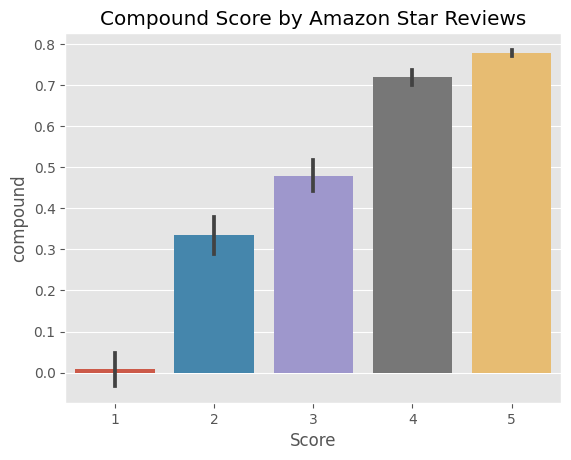

In [20]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon Star Reviews')
plt.show()

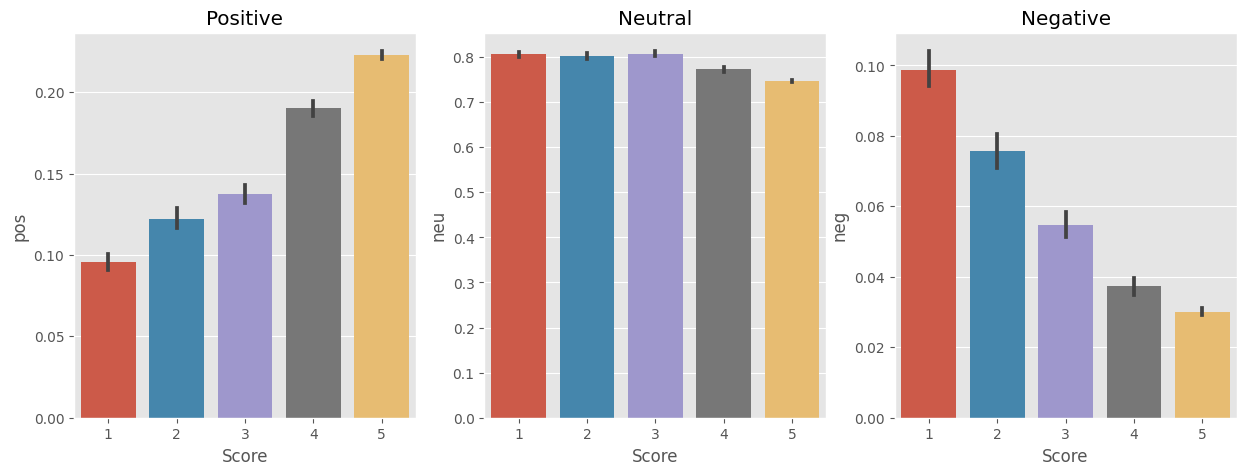

In [21]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# Step-3 RoBERTa Pretrained Model

* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [23]:
MODEL= f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)

In [25]:
def polarity_scores_roberta(example):
    # Run for RoBERTa Model on GPU
    encoded_text=tokenizer(example, return_tensors='pt')
    encoded_text={key:value.to(device) for key, value in encoded_text.items()}
    output = model(**encoded_text)
    scores= output[0][0].detach().cpu().numpy()
    scores=softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
    }
    return scores_dict

In [26]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [27]:
# Polarity_scores_roberta results on example
print(example)
polarity_scores_roberta(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687481,
 'roberta_pos': 0.002957372}

In [28]:
res = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
    try:
        text = row['Text']
        if len(text)>570 :
            text= text[:570]
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_results_rename= {}
        for key, value in vader_result.items():
            vader_results_rename[f"vader_{key}"]=value
        roberta_result = polarity_scores_roberta(text)
        both= {**vader_results_rename,**roberta_result}
        res[myid]=both
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df,how='left')

# Compare Scores Between Models

In [30]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

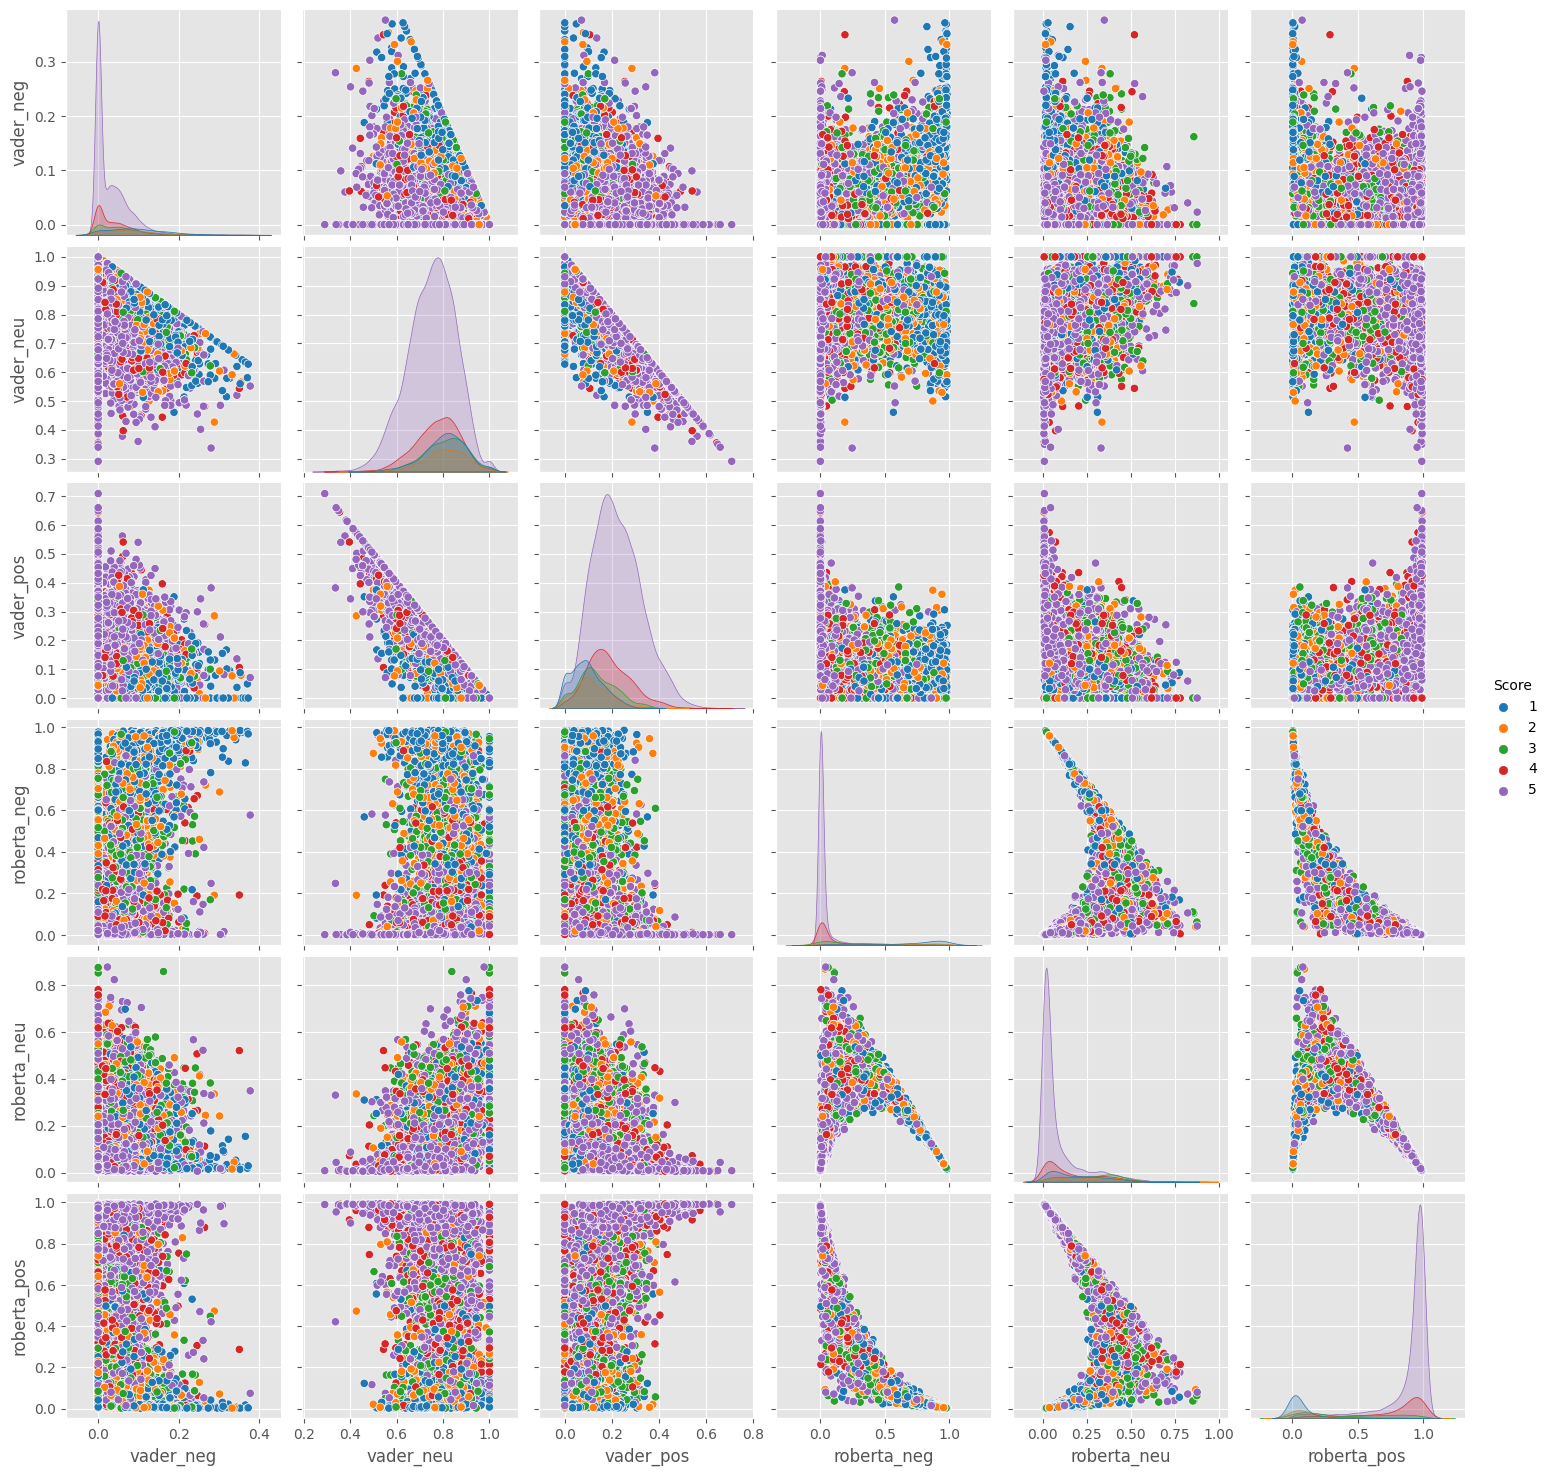

In [32]:
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(data=results_df,
             vars=['vader_neg','vader_neu','vader_pos',
                  'roberta_neg','roberta_neu','roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

# Step-4 Review Examples:
* Positive 1-Star and Negative 5-Star Reviews

Positive 1-Star

In [37]:
results_df.query("Score == 1 ")\
    .sort_values('roberta_pos',ascending=False)['Text'].values[1]

'You can get these SOOOOOOOOOOOOO much cheaper at wholesale clubs.<br /><br />I get the 24/20oz(yes 20oz!) for $11 or $12!! Its actually even cheaper then buying the bottles from the regular store!'

In [43]:
results_df.query("Score == 1 ")\
    .sort_values('vader_pos',ascending=False)['Text'].values[12]

'This has to be without a doubt the WORST tasting Hot Chocolate ever! The best way to describe the taste of "This Stuff" is really cheap suger free instant hot chocolate. Swiss Miss instant is way better and cost less. After only 3 cups threw the rest in the garbage where it belongs and canceled my subscribe and save for this "SLOP"!'

Negative 5 Star

In [44]:
results_df.query("Score == 5 ")\
    .sort_values('roberta_neg',ascending=False)['Text'].values[1]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [47]:
results_df.query("Score == 5 ")\
    .sort_values('vader_neg',ascending=False)['Text'].values[12]

'Very good taste and a good price, no sales tax, no shipping charges and delivered to my door'

# Step-5 The Transformers Pipeline
* Quick & easy way to run sentiment analysis

In [48]:
from transformers import pipeline 
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [57]:
sent_pipeline('You can get these SOOOOOOOOOOOOO much cheaper at wholesale clubs.<br /><br />I get the 24/20oz(yes 20oz!) for $11 or $12!! Its actually even cheaper then buying the bottles from the regular store!')

[{'label': 'NEGATIVE', 'score': 0.8580608367919922}]

In [56]:
sent_pipeline('this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault')

[{'label': 'NEGATIVE', 'score': 0.9980344176292419}]

In [55]:
sent_pipeline("This has to be without a doubt the WORST tasting Hot Chocolate ever! The best way to describe the taste of 'This Stuff' is really cheap suger free instant hot chocolate. Swiss Miss instant is way better and cost less. After only 3 cups threw the rest in the garbage where it belongs and canceled my subscribe and save for this SLOP")

[{'label': 'NEGATIVE', 'score': 0.9997459053993225}]